Generate random captcha images used later for training and validation.

In [5]:
%matplotlib inline

from pathlib import Path
import sys
sys.path.append("../../")

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

from tqdm.auto import trange
import pyrip

data_dir = Path('/home/hadim/.data/Neural_Network/pyrip')

dataset_dir = data_dir / 'dataset'
dataset_dir.mkdir(exist_ok=True, parents=True)

train_data_path = dataset_dir / 'training.tfrecord'
val_data_path = dataset_dir / 'validation.tfrecord'

alphabet_path = dataset_dir / "alphabet.txt"
tokenizer_path = dataset_dir / "tokenizer"

In [3]:
n_images = 20000
image_size = (400, 120)
watermark = "République française - Référendum d'initiative partagée"

word_length_min = 5
word_length_max = 10

generator = pyrip.captcha_solver.CaptchaGenerator(image_size=image_size, font_size=60)

# Create a tokenizer and save it.
vocabulary = set(generator.alphabet)
# This is the padding value.
vocabulary.add(pyrip.captcha_solver.PADDING_VALUE)
tokenizer = tfds.features.text.TokenTextEncoder(vocabulary)
tokenizer.save_to_file(str(tokenizer_path))

# Split dataset for training and validation.
train_size = 0.8
train_n = int(n_images * train_size)

train_writer = tf.io.TFRecordWriter(str(train_data_path))
val_writer = tf.io.TFRecordWriter(str(val_data_path))

for i in trange(n_images):
  # Generate a random word and an image.
  word, image = generator(n_min=word_length_min, n_max=word_length_max, watermark=watermark)
  image = image.convert('RGB')
  
  # Pad label with a padding value.
  word_padded = word.ljust(word_length_max, pyrip.captcha_solver.PADDING_VALUE)
  
  # Create TF feature
  example = pyrip.captcha_solver.encode_data(image, word_padded, tokenizer)
  
  if i < train_n:
    writer = train_writer
  else:
    writer = val_writer
    
  # Save data to TFRecord.
  writer.write(example.SerializeToString())
  
train_writer.close()
val_writer.close()
  
# Save the alphabet.
with open(alphabet_path, 'w') as f:
  f.write(''.join(generator.alphabet))

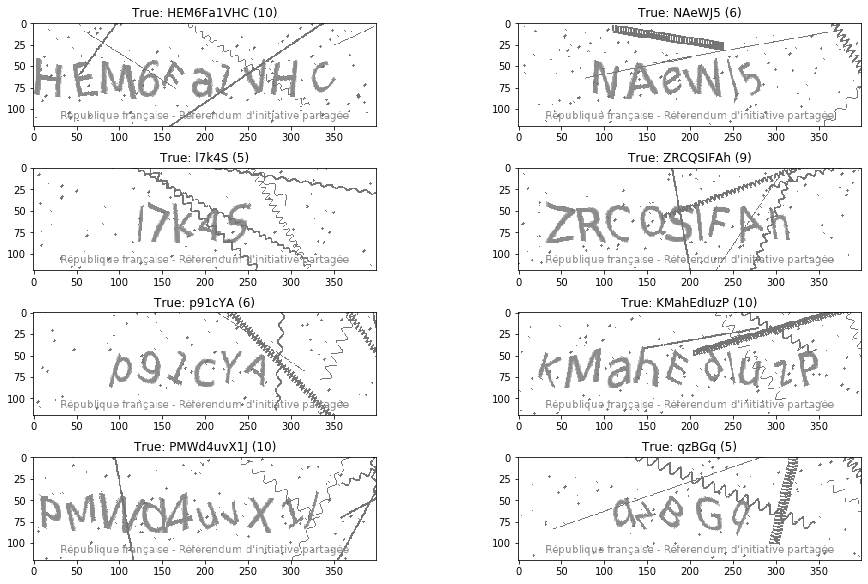

In [7]:
# Check the dataset by displaying some images.

n  = 8
dataset = tf.data.TFRecordDataset(str(train_data_path))
dataset = dataset.map(map_func=pyrip.captcha_solver.decode_data(tokenizer, input_as_dict=True))
dataset = dataset.shuffle(1024)
dataset = dataset.batch(n)
data = [d for d in dataset.take(1)][0]

images = data['image']
labels = data['label']

# Plot
original_images = data['original_image'].numpy()
words = data['word'].numpy()
words = [w.decode('utf-8').replace('0', '') for w in words]

size = 2
ncols = 2
nrows = n // ncols
ratio = images.shape[2] / images.shape[1]
figsize = (ncols * size * ratio, size * nrows)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
axs = axs.flatten()

for image, word, ax in zip(original_images, words, axs):
  ax.imshow(image)
  
  text = f'True: {word} ({len(word)})'
  ax.set_title(text)